In [2]:
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra.auth import PlainTextAuthProvider
from cassandra import WriteTimeout

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType

import pandas as pd
import numpy as np

from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

import csv

import yfinance as yf
from datetime import datetime, timedelta
import time
from tqdm import tqdm

## Load Ticker Information

### List of helper functions

In [3]:
# Load ticker symbols from nasdaq screener csv file
def load_tickers(filepath):
    df = pd.read_csv(filepath)
    return df.iloc[:, 0].tolist()

In [4]:
# Fetch historical data for a given ticker
def fetch_stock_data(ticker):
    # Calculate the date 5 years ago from today
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*5)
    
    # Fetch historical data
    data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    return data

In [5]:
import os
import pandas as pd

def clean_and_truncate_csv_files(subdirectory):
    file_lengths = {}
    files = [file for file in os.listdir(subdirectory) if file.endswith('.csv')]

    # Read each file and record its length
    for filename in files:
        filepath = os.path.join(subdirectory, filename)
        try:
            df = pd.read_csv(filepath)
            file_lengths[filepath] = len(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    # Calculate the median length
    if file_lengths:
        lengths = list(file_lengths.values())
        median_length = sorted(lengths)[len(lengths) // 2]

        # Remove files that are shorter than the median length or truncate those that are longer
        for filepath, length in file_lengths.items():
            if length < median_length:
                try:
                    os.remove(filepath)
                    print(f"Removed {filepath} because its length {length} is less than the median length {median_length}.")
                except Exception as e:
                    print(f"Failed to remove {filepath}: {e}")
            elif length > median_length:
                try:
                    # Read the file again (or use the dataframe if stored in memory)
                    df = pd.read_csv(filepath)
                    # Truncate by dropping initial rows
                    df_truncated = df.iloc[length - median_length:]
                    # Overwrite the original file
                    df_truncated.to_csv(filepath, index=False)
                    print(f"Truncated {filepath} from {length} to {median_length} rows.")
                except Exception as e:
                    print(f"Error truncating {filepath}: {e}")
    else:
        print("No valid CSV files found or all files failed to read.")



### Load tickers to local .CSV subdirectory

In [ ]:
# Load ticker symbols
tickers = load_tickers('nasdaq_screener.csv')

# Create a subfolder for the financial data
output_dir = 'fin_data'
os.makedirs(output_dir, exist_ok=True)

# Dictionary to hold data for all tickers
all_data = {}

# Loop through each ticker and fetch its data
index = 0
for ticker in tqdm(tickers):
    try:
        data = fetch_stock_data(ticker)
        all_data[ticker] = data
        # Save data
        data.to_csv(os.path.join(output_dir, f'{ticker}_5_years_data.csv'))
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")

# For ease of processing, remove all csv files that don't have less than median length or truncate those longer.
clean_and_truncate_csv_files(output_dir)

## Upload to Cassandra database

### List of helper functions

In [6]:
def create_schema(session):
    # CQL to create a keyspace
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS fin_data WITH replication = {
            'class': 'SimpleStrategy', 
            'replication_factor': 1
        }
    """)

    # CQL to use the keyspace
    session.execute("USE fin_data")

    # CQL to create a table
    session.execute("""
        CREATE TABLE IF NOT EXISTS ohlcv (
            symbol text,
            date timestamp,
            open double,
            high double,
            low double,
            close double,
            adj_close double,
            volume bigint,
            PRIMARY KEY (symbol, date)
        )
    """)

In [7]:
def parse_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

In [8]:
def execute_with_retries(session, batch, max_retries=5):
    retries = 0
    backoff_time = 2  # Start with 2 seconds backoff time
    while retries < max_retries:
        try:
            session.execute(batch)
            break  # Break the loop if execution is successful
        except WriteTimeout:
            print(f"WriteTimeout: retrying {retries+1}/{max_retries} after {backoff_time}s...")
            time.sleep(backoff_time)  # Sleep for backoff_time seconds before retrying
            backoff_time *= 2  # Double the backoff time for the next retry
            retries += 1
    if retries == max_retries:
        print("Failed to execute batch after several retries.")

In [9]:
def load_data(session, file_path, symbol):
    batch = BatchStatement()
    batch_size = 0  # Track the size of the batch

    with open(file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            batch.add(
                """
                INSERT INTO fin_data.ohlcv (symbol, date, open, high, low, close, adj_close, volume)
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
                """,
                (symbol, parse_date(row['Date']), float(row['Open']), float(row['High']),
                 float(row['Low']), float(row['Close']), float(row['Adj Close']), int(row['Volume']))
            )
            batch_size += 1
            if batch_size >= 100:  # Execute batch after collecting 100 statements
                execute_with_retries(session, batch)
                batch = BatchStatement()  # Reset batch after execution
                batch_size = 0  # Reset batch size

        if batch_size > 0:  # Ensure any remaining statements are executed
            execute_with_retries(session, batch)

        print(f"Data from {symbol} loaded successfully.")

In [10]:
def drop_table(keyspace_name, table_name):
    """ Drop a table in a given keyspace """
    # Set up connection parameters
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')  # Update credentials if needed
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider)  # Adjust IP if Cassandra is hosted elsewhere
    session = cluster.connect(keyspace_name)  # Connect to the specified keyspace

    # Drop table
    try:
        session.execute(f"DROP TABLE IF EXISTS {table_name};")
        print(f"Table {table_name} has been dropped successfully.")
    except Exception as e:
        print(f"An error occurred while dropping the table: {e}")
    finally:
        # Clean up, close the session and cluster connection
        session.shutdown()
        cluster.shutdown()

In [11]:
def create_table():
    # Connect to Cassandra
    # Adjust the connection settings as needed for your setup
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')  # Update with actual credentials
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider)
    session = cluster.connect()

    # Create the schema
    create_schema(session)

    print("Keyspace and table created successfully.")

    # Clean up
    session.shutdown()
    cluster.shutdown()

In [12]:
create_table()

Keyspace and table created successfully.


### Upload to database

In [ ]:
cluster = Cluster(['127.0.0.1'])  # Adjust if Cassandra is hosted elsewhere
session = cluster.connect()

data_dir = '/home/xca7/Desktop/Storage-Solutions-for-Big-Data-CA1/fin_data'
for filename in tqdm(os.listdir(data_dir)):
    if filename.endswith('.csv'):
        symbol = filename.split('_')[0]  # Extract the symbol from the filename
        load_data(session, os.path.join(data_dir, filename), symbol)

session.shutdown()
cluster.shutdown()

## PySpark functions

In [14]:
def create_spark_session():
    spark = SparkSession.builder \
        .appName("Cassandra Integration Example") \
        .config("spark.cassandra.connection.host", "localhost") \
        .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.5.0") \
        .getOrCreate()
    return spark

In [ ]:
# Initialize Spark session
spark = create_spark_session()

In [16]:
def list_unique_symbols(spark, keyspace, table):
    # Load the data from Cassandra into a DataFrame
    df = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(keyspace=keyspace, table=table) \
        .load()
    
    # Select distinct symbols and collect them into a list
    symbols = df.select("symbol").distinct().collect()
    
    # Extract symbols from rows
    symbol_list = [row['symbol'] for row in symbols]
    print("Unique symbols:", symbol_list)
    return symbol_list

In [17]:
keyspace = 'fin_data'
table = 'ohlcv'
symbols = list_unique_symbols(spark, keyspace, table)
len(symbols)

Unique symbols: ['SPGI', 'HUBS', 'HGV', 'CHDN', 'OSK', 'PGP', 'BRKR', 'TC', 'RBA', 'CASI', 'CAPL', 'CENT', 'EOT', 'NXE', 'APYX', 'DUK', 'YUMC', 'LANV', 'DLB', 'MTD', 'IGIC', 'DAWN', 'SCCO', 'CZFS', 'INZY', 'STRS', 'OI', 'AQMS', 'FOSL', 'PEB', 'EOD', 'KIM', 'VGM', 'TWO', 'DGX', 'ATNF', 'PRU', 'AAPL', 'RA', 'ADNT', 'TSN', 'ADVM', 'LINC', 'CLDX', 'MRTN', 'CATO', 'PHIO', 'LIXTW', 'HDSN', 'NFG', 'CVLT', 'CPT', 'PRQR', 'RFIL', 'SLGN', 'BRT', 'IBCP', 'ACA', 'ZIONL', 'OBE', 'SM', 'JBLU', 'CORZW', 'PRFT', 'BRSP', 'PNC', 'RGLS', 'LPLA', 'LPX', 'ATXS', 'KZR', 'GFF', 'EXAS', 'CPHC', 'KFFB', 'FORTY', 'OSUR', 'GWRE', 'LDTC', 'SIRI', 'GRRR', 'SWX', 'AGI', 'MPC', 'UNB', 'WKHS', 'ABEO', 'ODC', 'BTTR', 'GERN', 'AVTR', 'MVIS', 'DXLG', 'IROH', 'WCC', 'JCTCF', 'EMR', 'SMMF', 'ANGI', 'VGR', 'EQIX', 'FRGT', 'CDTX', 'MSD', 'RDIB', 'CCJ', 'FULT', 'SIM', 'SOHU', 'RBB', 'CNQ', 'CIG', 'RDWR', 'OCFCP', 'MCRI', 'IPW', 'SAMG', 'MLI', 'AAP', 'CL', 'CDE', 'NNN', 'TRUE', 'NUV', 'MINM', 'SRI', 'ZDGE', 'OCSL', 'TLK', 'EX

4618

In [18]:
def query_symbol_data(spark, keyspace, table, symbol, start_date, end_date):
    # Load data from the specified table and keyspace
    df = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(keyspace=keyspace, table=table) \
        .load()

    # Filter data for the specified symbol and date range
    filtered_df = df.filter(
        (col("symbol") == symbol) & 
        (col("date") >= start_date) & 
        (col("date") <= end_date)
    )

    # Convert to Pandas DataFrame
    pandas_df = filtered_df.toPandas()

    # Ensure the 'symbol' column is set correctly
    pandas_df['symbol'] = symbol

    # Convert date column to proper datetime format
    pandas_df['date'] = pd.to_datetime(pandas_df['date'])

    return pandas_df


## Construct Optimal Portfolio

### List of helper functions

In [20]:
def risk_and_return_analysis(stock_data, risk_free_rate=0.1):
    returns_data = {}

    for symbol, data in stock_data.items():
        if 'close' in data.columns:
            daily_returns = data['close'].pct_change().dropna()
            annual_returns = np.mean(daily_returns) * 252  # assuming 252 trading days in a year
            annual_volatility = np.std(daily_returns) * np.sqrt(252)

            if annual_volatility == 0:
                sharpe_ratio = np.nan  # Assign NaN or another special value if volatility is zero
            else:
                sharpe_ratio = (annual_returns - risk_free_rate) / annual_volatility

            returns_data[symbol] = {
                'Return': annual_returns,
                'Volatility': annual_volatility,
                'Sharpe Ratio': sharpe_ratio,
                'OHLCV': data
            }
        else:
            print(f"Warning: 'close' column not found in DataFrame for {symbol}")

    summary_df = pd.DataFrame(returns_data).T  # Transpose to make symbols as rows
    filtered_df = summary_df[summary_df['Sharpe Ratio'] > 1]

    return filtered_df

In [21]:
import matplotlib.pyplot as plt

def plot_metrics(df):
    ncols = 5
    nrows = -(-len(df) // ncols)  # Ceiling division to calculate the number of rows needed
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 3*nrows), sharex=True)

    # Flatten axes if there's only one row
    if nrows == 1:
        axes = [axes]

    for i, (symbol, data) in enumerate(df.iterrows()):
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]

        bars = ax.bar(['Return', 'Volatility', 'Sharpe Ratio'], data[['Return', 'Volatility', 'Sharpe Ratio']], color=['blue', 'green', 'orange'])
        ax.set_title(f'Metrics for {symbol}')
        ax.set_ylabel('Value')

        # Add value labels to the bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Hide empty subplots
    for i in range(len(df), nrows * ncols):
        row = i // ncols
        col = i % ncols
        fig.delaxes(axes[row][col])

    plt.xlabel('Metrics')
    plt.tight_layout()
    plt.show()


In [22]:
def diversification_through_correlation(risk_adjusted_portfolio, threshold=0.5):
    # Create a copy of the input DataFrame to avoid modifying the original
    uncorrelated_data = risk_adjusted_portfolio.copy()

    # Extract 'close' prices and consolidate into a single DataFrame
    close_prices = {}
    for symbol, row in risk_adjusted_portfolio.iterrows():
        # Check if 'OHLCV' DataFrame exists and contains 'close' data
        if 'OHLCV' in row and 'close' in row['OHLCV'].columns:
            close_prices[symbol] = row['OHLCV']['close']

    # Convert dictionary to DataFrame
    close_prices_df = pd.DataFrame(close_prices)

    # Handle the case where no valid 'close' data is found
    if close_prices_df.empty:
        print("No valid 'close' data found in the input DataFrame.")
        return pd.DataFrame()  # Return an empty DataFrame with the same structure

    # Calculate the correlation matrix
    corr_matrix = close_prices_df.corr()

    # Calculate average correlation for each stock
    avg_correlations = corr_matrix.mean().sort_values()

    # Filter stocks based on the threshold and ensure correlations are not negative
    uncorrelated_symbols = avg_correlations[(-threshold < avg_correlations) & (avg_correlations < threshold)].index.tolist()

    # Filter the original DataFrame for uncorrelated symbols
    uncorrelated_data = uncorrelated_data.loc[uncorrelated_symbols]

    return uncorrelated_data


In [23]:
def plot_close_correlation_heatmap(df):
    # Extract 'close' data for each symbol
    close_data = pd.concat([df.loc[symbol]['OHLCV']['close'] for symbol in df.index], axis=1)
    close_data.columns = df.index  # Set columns to symbol names

    # Compute the correlation matrix
    corr_matrix = close_data.corr()

    # Plot the correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of Close Prices')
    plt.show()


In [24]:
def plot_normalized_portfolio_returns(risk_adjusted_portfolio):
    normalized_returns = pd.DataFrame()

    for symbol, data in risk_adjusted_portfolio.iterrows():
        try:
            ohlcv = data.get('OHLCV')
            if ohlcv is not None and 'close' in ohlcv.columns:
                ohlcv.index = pd.to_datetime(ohlcv.index)  # Ensure index is datetime
                daily_returns = ohlcv['close'].pct_change().dropna()

                normalized_daily_returns = (1 + daily_returns).cumprod()
                normalized_returns[symbol] = normalized_daily_returns
        except Exception as e:
            print(f"Failed to process {symbol}: {e}")

    if not normalized_returns.empty:
        normalized_returns.plot(figsize=(14, 7))
        plt.title('Normalized Returns of Portfolio Assets')
        plt.xlabel('Date')
        plt.ylabel('Normalized Returns')
        plt.legend(title='Symbol', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()
    else:
        print("No valid data available to plot.")


In [25]:
def optimize_portfolio_weights(risk_adjusted_portfolio, target_return=0.2, risk_free_rate=0.3):
    # Extract 'close' prices and calculate returns
    close_prices = {}
    for symbol, row in risk_adjusted_portfolio.iterrows():
        if 'OHLCV' in row and 'close' in row['OHLCV'].columns:
            close_prices[symbol] = row['OHLCV']['close']
    
    if not close_prices:
        print("No valid 'close' data found in the input DataFrame.")
        return {}

    # Create a DataFrame from the close prices dictionary
    close_prices_df = pd.DataFrame(close_prices)

    # Calculate daily returns
    returns = close_prices_df.pct_change(fill_method=None).dropna()


    # Calculate the covariance matrix
    covariance_matrix = returns.cov()
    num_assets = len(returns.columns)

    # Constraints (weights sum to 1 and achieve target return)
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # weights must sum to 1
        {'type': 'eq', 'fun': lambda weights: returns.mul(weights).sum().mean() * 252 - target_return}  # target return
    ]
    bounds = tuple((0, 1) for _ in range(num_assets))

    # Objective function (portfolio variance)
    def portfolio_variance(weights):
        return weights.T @ covariance_matrix @ weights

    # Adjust initial guess
    # You can potentially start from a random distribution of weights that sum to 1
    initial_weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]

    # Minimize the portfolio variance with a higher iteration limit
    options = {'maxiter': 1000}  # Increase max iterations if needed
    result = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints, options=options)


    # Return a dictionary of stock symbols and their weights if optimization is successful
    if result.success:
        optimized_weights = dict(zip(returns.columns, result.x))
        return optimized_weights
    else:
        print("Optimization failed:", result.message)
        return {}

In [26]:
def create_composite_asset(risk_adjusted_portfolio, weights):
    # Initialize DataFrame to store the weighted OHLCV data
    composite_ohlcv = pd.DataFrame()

    # Specify which columns are numeric and should be processed
    numeric_columns = ['adj_close', 'close', 'high', 'low', 'open', 'volume']

    for symbol, row in risk_adjusted_portfolio.iterrows():
        if symbol in weights and 'OHLCV' in row:
            # Extract the OHLCV DataFrame for the current symbol
            ohlcv_data = row['OHLCV']
            
            # Ensure the date column is preserved and set as index if not already
            if 'date' in ohlcv_data.columns and not ohlcv_data.index.name == 'date':
                ohlcv_data.set_index('date', inplace=True)

            # Select only the numeric columns for processing
            numeric_ohlcv = ohlcv_data[numeric_columns].copy()

            # Convert numeric columns to float, handling non-numeric entries gracefully
            numeric_ohlcv = numeric_ohlcv.apply(pd.to_numeric, errors='coerce')

            # Drop rows where any NaNs are introduced by conversion in numeric columns
            numeric_ohlcv = numeric_ohlcv.dropna()

            if numeric_ohlcv.empty:
                print(f"No valid numeric data for {symbol} after conversion.")
                continue

            # Multiply each numeric column by the weight of the stock in the portfolio
            weighted_ohlcv = numeric_ohlcv.multiply(weights[symbol])

            # Add the weighted OHLCV data to the composite DataFrame
            if composite_ohlcv.empty:
                composite_ohlcv = weighted_ohlcv
            else:
                composite_ohlcv = composite_ohlcv.add(weighted_ohlcv, fill_value=0)

    # Reset index to bring the date back as a column, if it was used as an index
    if composite_ohlcv.index.name == 'date':
        composite_ohlcv.reset_index(inplace=True)

    # Convert the 'date' column from integer/nanosecond timestamp to a readable datetime format
    if 'date' in composite_ohlcv.columns:
        composite_ohlcv['date'] = pd.to_datetime(composite_ohlcv['date'], unit='ns')

    return composite_ohlcv

In [30]:
# Example usage
keyspace = 'fin_data'
table = 'ohlcv'
start_date = '2021-01-01'  # Example start date
end_date = '2024-01-01'  # Example end date

# Benchmark Tickers
tickers = {
    'Global Market (VT)': 'VT',
    'US Market (DJI)': 'DJI',
    'Large Cap Stocks (SPY)': 'SPY',
    'Small Cap Stocks (IWM)': 'IWM'
}
    
all_data = {}
for symbol in tqdm(symbols):
    all_data[symbol] = query_symbol_data(spark, keyspace, table, symbol, start_date, end_date)

100%|██████████| 500/500 [01:38<00:00,  5.08it/s]


In [31]:
diversified_and_risk_adjusted_portfolio = diversification_through_correlation(
                                            risk_and_return_analysis(all_data), 
                                            threshold=0.5
                                        )

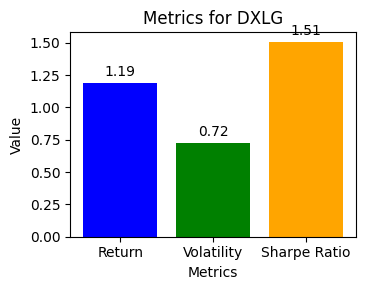

In [32]:
plot_metrics(diversified_and_risk_adjusted_portfolio)

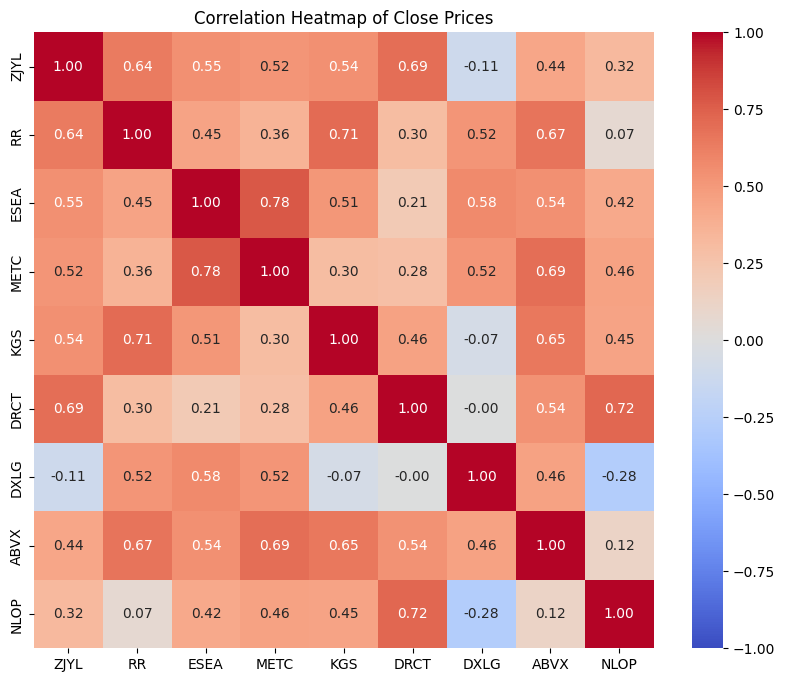

In [706]:
plot_close_correlation_heatmap(diversified_and_risk_adjusted_portfolio)

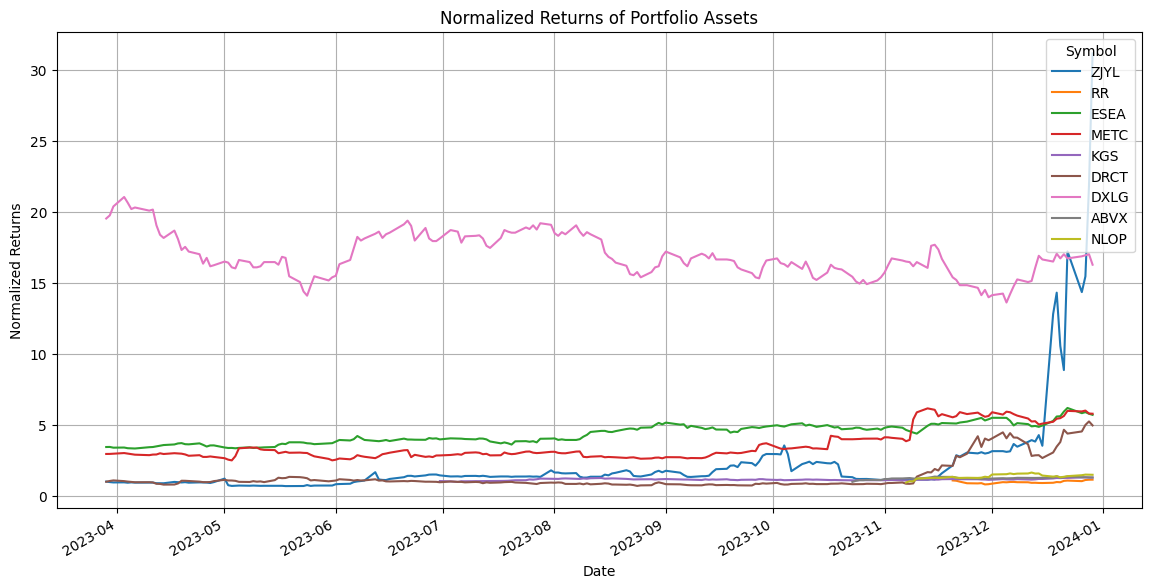

In [709]:
plot_normalized_portfolio_returns(diversified_and_risk_adjusted_portfolio)

### Construct an artificial asset that represents the portfolio

In [ ]:
generic_asset = create_composite_asset(
                    diversified_and_risk_adjusted_portfolio, 
                    optimize_portfolio_weights(diversified_and_risk_adjusted_portfolio)
                )

### Comparison of Portfolio against some benchmarks

In [700]:
def fetch_data(ticker, start_date, end_date):
    """Fetches adjusted close prices from Yahoo Finance for a given ticker within specified dates."""
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        print(f"No data fetched for {ticker}.")
    return data['Adj Close']

def calculate_returns(price_series):
    """Calculates daily returns from a time series of prices."""
    returns = price_series.pct_change().dropna()  # Calculate percent change and drop the first NaN
    return returns

def plot_normalized_generic_returns(data_dict, generic_asset_close_series):
    """
    Plot normalized returns, handling non-aligned data by reindexing and filling missing data.
    """
    # Create an empty DataFrame to store normalized returns
    normalized_returns = pd.DataFrame()

    # Process the generic asset
    if generic_asset_close_series is not None and not generic_asset_close_series.empty:
        try:
            # Calculate daily returns for the generic asset
            generic_returns = generic_asset_close_series.pct_change().dropna()
            # Normalize the returns to start at 1
            normalized_generic_returns = (1 + generic_returns).cumprod()
            # Store the normalized returns
            normalized_returns['Generic Asset'] = normalized_generic_returns
        except Exception as e:
            print(f"Failed to process Generic Asset: {e}")

    # Define a complete date range from the earliest start to the latest end across all series
    all_dates = sorted(set(generic_asset_close_series.dropna().index).union(*[data.dropna().index for data in data_dict.values()]))

    # Process each series in the dictionary
    for name, data in data_dict.items():
        if data is not None and not data.empty:
            try:
                # Calculate daily returns
                daily_returns = data.pct_change().dropna()
                # Normalize the returns to start at 1
                normalized_daily_returns = (1 + daily_returns).cumprod()
                # Reindex and forward fill to handle missing dates
                normalized_daily_returns = normalized_daily_returns.reindex(all_dates, method='ffill')
                # Store the normalized returns
                normalized_returns[name] = normalized_daily_returns
            except Exception as e:
                print(f"Failed to process {name}: {e}")

    # Reindex the generic asset to the same date range and forward fill
    if 'Generic Asset' in normalized_returns:
        normalized_returns['Generic Asset'] = normalized_returns['Generic Asset'].reindex(all_dates, method='ffill')

    # Check if the DataFrame is not empty
    if not normalized_returns.empty:
        # Plotting the normalized returns
        normalized_returns.plot(figsize=(14, 7))
        plt.title('Normalized Returns Comparison Including Generic Asset')
        plt.xlabel('Date')
        plt.ylabel('Normalized Returns')
        plt.legend(title='Asset')
        plt.grid(True)
        plt.show()
    else:
        print("No valid data available to plot.")

In [701]:
def compare_asset_performance(data_dict, generic_asset_close_series):
    
    # Create an empty DataFrame to store normalized returns
    performance_comparison = pd.DataFrame()

    # Process the generic asset
    if generic_asset_close_series is not None and not generic_asset_close_series.empty:
        try:
            # Calculate daily returns for the generic asset
            generic_returns = generic_asset_close_series.pct_change().dropna()
            # Normalize the returns to start at 1
            normalized_generic_returns = (1 + generic_returns).cumprod()
            # Store the final value
            performance_comparison['Generic Asset'] = [normalized_generic_returns.iloc[-1]]
        except Exception as e:
            print(f"Failed to process Generic Asset: {e}")

    # Process each series in the dictionary
    for name, data in data_dict.items():
        if data is not None and not data.empty:
            try:
                # Calculate daily returns
                daily_returns = data.pct_change().dropna()
                # Normalize the returns to start at 1
                normalized_daily_returns = (1 + daily_returns).cumprod()
                # Store the final value
                performance_comparison[name] = [normalized_daily_returns.iloc[-1]]
            except Exception as e:
                print(f"Failed to process {name}: {e}")

    # Printing and plotting the performance comparison
    if not performance_comparison.empty:
        performance_comparison = performance_comparison.T
        performance_comparison.columns = ['Normalized Final Returns']
        performance_comparison.sort_values(by='Normalized Final Returns', inplace=True)

        # Print out the returns
        print("\nNormalized Final Returns:")
        print(performance_comparison)

        # Print comparison to generic asset
        if 'Generic Asset' in performance_comparison.index:
            generic_return = performance_comparison.loc['Generic Asset', 'Normalized Final Returns']
            comparison = (performance_comparison / generic_return - 1) * 100
            print("\nPerformance relative to Generic Asset (%):")
            print(comparison)

        performance_comparison.plot(kind='bar', legend=None, figsize=(14, 7), color='skyblue')
        plt.title('Comparison of Final Normalized Returns')
        plt.xlabel('Assets')
        plt.ylabel('Normalized Final Returns')
        plt.grid(True, linestyle='--')
        plt.show()
    else:
        print("No valid data available for comparison.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Normalized Final Returns:
                        Normalized Final Returns
Small Cap Stocks (IWM)              1.078068e+00
US Market (DJI)                     1.121341e+00
Global Market (VT)                  1.190112e+00
Large Cap Stocks (SPY)              1.347376e+00
Generic Asset                       2.624026e+16

Performance relative to Generic Asset (%):
                        Normalized Final Returns
Small Cap Stocks (IWM)                    -100.0
US Market (DJI)                           -100.0
Global Market (VT)                        -100.0
Large Cap Stocks (SPY)                    -100.0
Generic Asset                                0.0


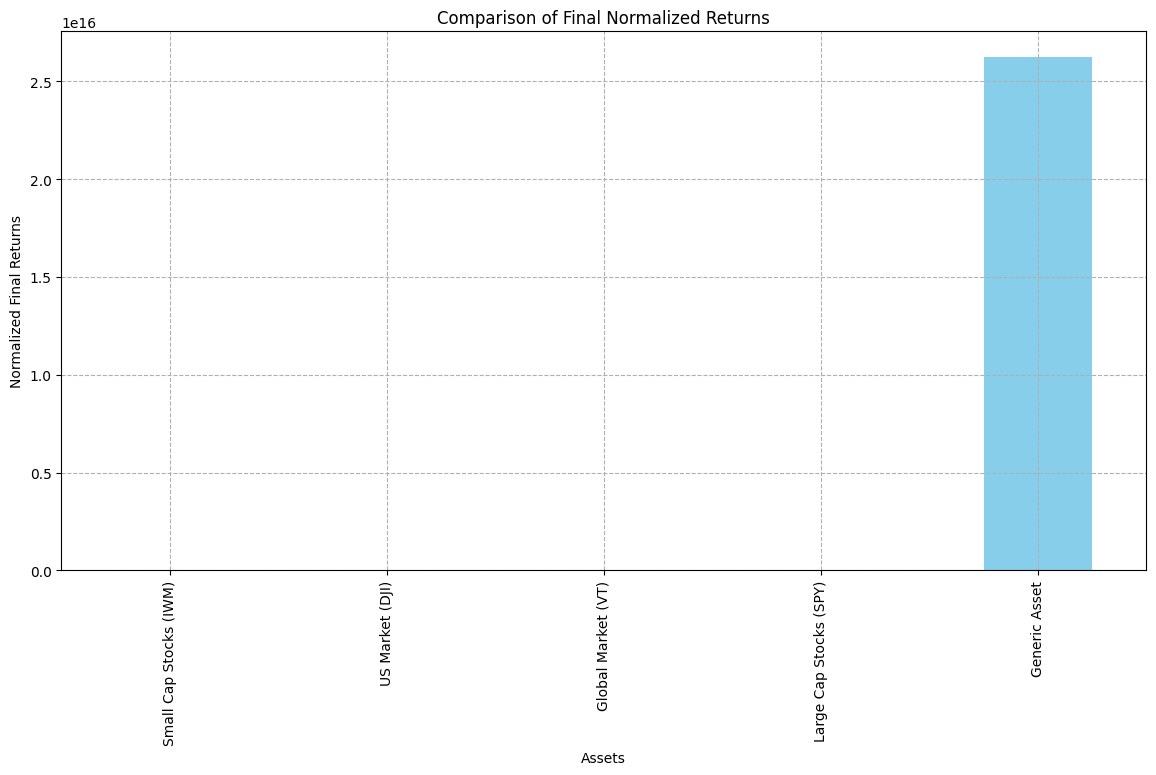

In [702]:
# Fetch and store ndata in a dictionary
benchmark_data = {name: fetch_data(ticker, start_date, end_date) for name, ticker in tickers.items()}

# Example usage assuming data_dict is already populated with your financial data.
#plot_normalized_generic_returns(benchmark_data, generic_asset['close'])
c#ompare_asset_performance(benchmark_data, generic_asset['close'])

In [679]:
def create_portfolio_schema(session):
    # CQL to create a keyspace for portfolio data
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS portfolio_data WITH replication = {
            'class': 'SimpleStrategy', 
            'replication_factor': 1
        }
    """)

    # CQL to use the keyspace
    session.execute("USE portfolio_data")

    # CQL to create a table for the risk-adjusted portfolio data
    session.execute("""
        CREATE TABLE IF NOT EXISTS portfolio_metrics (
            symbol text,
            date timestamp,
            return double,
            volatility double,
            sharpe_ratio double,
            weight double,
            PRIMARY KEY (symbol, date)
        )
    """)

# Example usage assuming 'session' is your active Cassandra session
create_portfolio_schema(session)


NoHostAvailable: ('Unable to complete the operation against any hosts', {<Host: 127.0.0.1:9042 datacenter1>: ConnectionException('Pool is shutdown')})

In [ ]:
from cassandra.cluster import Cluster
from datetime import datetime

def insert_portfolio_data(session, risk_adjusted_portfolio):
    """
    Inserts data from a risk_adjusted_portfolio DataFrame into the Cassandra 'portfolio_metrics' table.

    Args:
        session (cassandra.cluster.Session): The Cassandra session object.
        risk_adjusted_portfolio (pandas.DataFrame): A DataFrame containing the portfolio data.
    """
    # Prepare the INSERT statement
    insert_query = session.prepare("""
        INSERT INTO portfolio_metrics (symbol, date, return, volatility, sharpe_ratio, weight)
        VALUES (?, ?, ?, ?, ?, ?)
    """)

    # Iterate over the DataFrame
    for index, row in risk_adjusted_portfolio.iterrows():
        # Assuming the DataFrame has 'Return', 'Volatility', 'Sharpe Ratio', and 'weight' columns
        # and that the 'date' for the entry needs to be supplied (here using the current date for all entries)
        symbol = index
        data_date = datetime.utcnow()  # This could also be a date column in the DataFrame if available

        # Get data from DataFrame
        ret = row['Return']
        volatility = row['Volatility']
        sharpe_ratio = row['Sharpe Ratio']
        weight = row['weight']

        # Execute the insert query
        session.execute(insert_query, (symbol, data_date, ret, volatility, sharpe_ratio, weight))

# Example usage
# Assuming you have a 'session' object from Cassandra driver and a DataFrame 'risk_adjusted_portfolio'
# cluster = Cluster(['127.0.0.1'])
# session = cluster.connect()
# insert_portfolio_data(session, risk_adjusted_portfolio)
